# Conditional object generation using pre-trained models and plug-in networks
Prowadzący: **Patryk Wielopolski**, Politechnika Wrocławska

Abstrakt: Modele generatywne przyciągnęły uwagę wielu praktyków uczenia maszynowego w ostatnich latach, co zaowocowało modelami takimi jak StyleGAN do generowania ludzkiej twarzy lub PointFlow do generowania chmur punktów 3D. Jednak domyślnie nie możemy kontrolować jego procesu próbkowania, tj. nie możemy wygenerować próbki z określonym zestawem atrybutów. Obecne podejście polega na przekwalifikowaniu modelu z dodatkowymi danymi wejściowymi i inną architekturą, co wymaga czasu i zasobów obliczeniowych.

Podczas tego praktycznego warsztatu omówimy metodę, która pozwala nam generować obiekty o danym zestawie atrybutów bez ponownego uczenia modelu bazowego. W tym celu wykorzystamy modele normalizing flows – Conditional Masked Autoregressive Flow i Conditional Real NVP oraz sieci Plugin, w wyniku których powstaje Flow Plugin Network.


Cel warsztatów:
 * Praktyczne zapoznanie się z modelami Normalizing Flows oraz biblioteką nflows
 * Praktyczne zapoznanie się z metodą Flow Plugin Network

Agenda:
 * Wstęp do modeli generatywnych
 * Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**.
 * Metoda Flow Plugin Network (FPN)
 * Wykorzystanie metody FPN do warunkowego generowania obrazów

# Wstęp do modeli generatywnych

## Modele dyskryminatywne vs. modele generatywne

**Model dyskryminatywny** jest modelem warunkowego prawdopodobieństwa ${P(Y\mid X=x)}$ zmiennej celu Y, biorąc pod uwagę obserwację x.
*Przykłady*: Regresja Logistyczna, Drzewa decyzyjne.

**Model generatywny** to model statystyczny wspólnego rozkładu prawdopodobieństwa ${P(X, Y)}$ na danej zmiennej obserwowalnej X i zmiennej docelowej Y.
*Przykłady*:

![](figures/three-generative-models.png)

## Normalizing Flows

 Normalizing Flows reprezentują grupę modeli generatywnych, które można efektywnie trenować poprzez bezpośrednią estymację wiarogodności dzięki zastosowaniu wzoru na zmianę zmiennej. W praktyce wykorzystują one szereg (parametrycznych) funkcji odwracalnych: $\mathbf{y}=\mathbf{f}_n \circ \dots \circ \mathbf{f}_1(\mathbf{z})$. Zakładając, że dany rozkład bazowy $p(\mathbf{z})$ dla $\mathbf{z}$, log likelihood dla $\mathbf{y}$ jest podane przez $\log p(\mathbf{y}) = \ log p(\mathbf{z}) - \sum_{n=1}^N \log \left| \det \frac{\partial \mathbf{f}_n}{\partial \mathbf{z}_{n-1}} \right|$. W praktycznych zastosowaniach $p(\mathbf{y})$ reprezentuje rozkład obserwowalnych danych, a $p(\mathbf{z})$ jest zwykle zakładany jako rozkład normalny z niezależnymi komponentami.



![](figures/normalizing-flow.png)

# Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**

Omówienie modeli:
  * NICE
  * RealNVP
  * MAF

Omówienie warunkowych modeli:
  * Conditional NICE
  * Conditional RealNVP
  * Conditional MAF

### Konstrukcja biblioteki nflows

Krótkie omówienie biblioteki

  * Distributions - Bazowe rozkłady prawdopodobieństwa
  * Flows - Przykładowe implementacje modeli normalizing flows
  * Nn - Implementacje sieci neuronowych budujących bloki modelu
  * Transforms - Implementacje bloków transformujących w normalazing flows
  * Utils

### Toy example data

In [1]:
# !pip install matplotlib nflows sklearn torch torchvision

In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

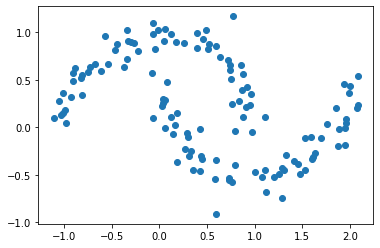

In [3]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

# NICE (Non-linear Independent Component Estimation)

Model NICE (Non-linear Independent Component Estimation) implementuje model normalizing flows poprzez układanie w stos sekwencji odwracalnych bijektywnych funkcji transformacji. W każdej bijekcji, znanej jako additive coupling layer, wymiary wejściowe są podzielone na dwie części:

 - Pierwsze wymiary pozostają takie same;
 - Druga część, do wymiarów, podlega transformacji addytywnej, tj. dodawany jest komponent przesunięcia.
$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})
\end{cases}
$$

In [4]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.normalization import BatchNorm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class NICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [5]:
nice = NICE(features=2, hidden_features=4, num_layers=1, num_blocks_per_layer=1)

In [6]:
# Sprawdźmy komponenty modelu
nice

NICE(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AdditiveCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (linear_layers): ModuleList(
                (0): Linear(in_features=4, out_features=4, bias=True)
                (1): Linear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=4, out_features=1, bias=True)
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)

In [7]:
nice = NICE(features=2, hidden_features=4, num_layers=4, num_blocks_per_layer=2)
nice_opt = optim.Adam(nice.parameters())

In [8]:
def train(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        opt.zero_grad()
        loss = -model.log_prob(inputs=x).mean()
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid = model.log_prob(xyinput).exp().reshape(100, 100)

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.title('iteration {}'.format(i + 1))
            plt.show()

/opt/homebrew/anaconda3/envs/datascience/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


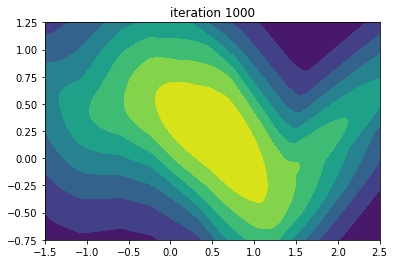

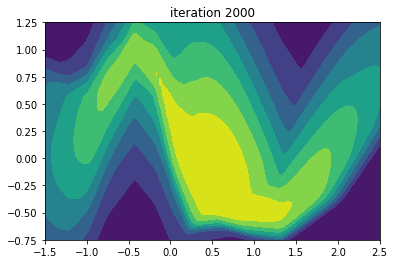

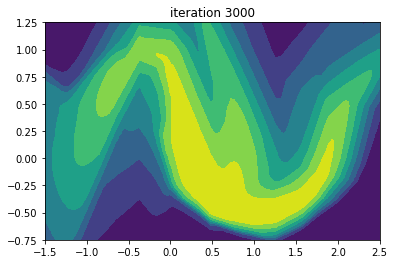

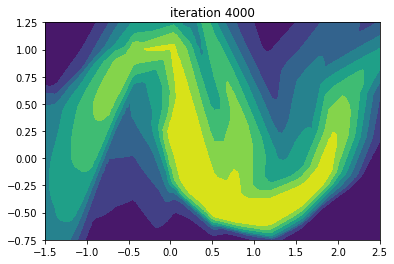

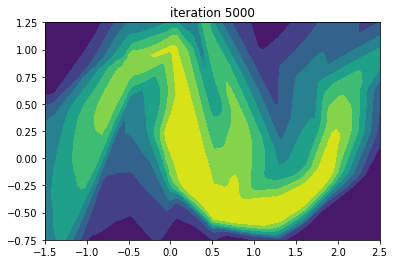

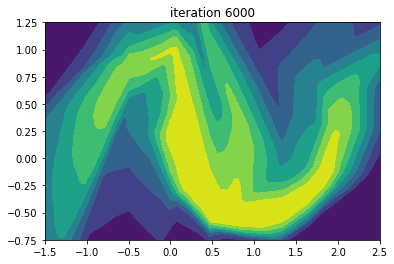

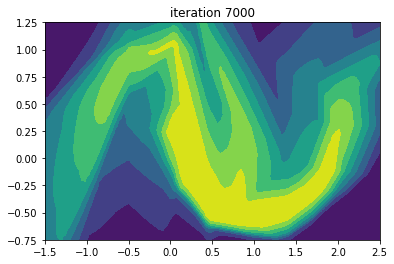

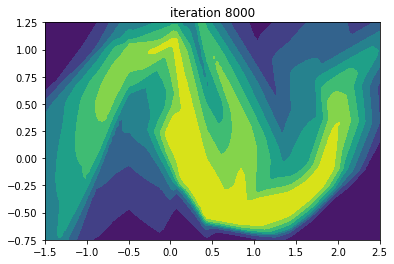

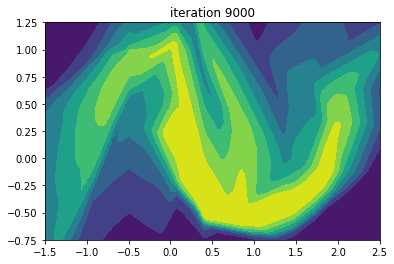

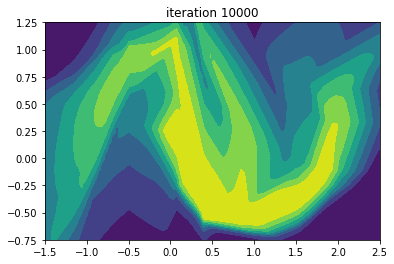

In [9]:
train(nice, nice_opt, num_iter=10000, iter_log=1000)

# Ćwiczenie (5 min.)

Modyfikując hiperparametry modelu wytrenuj model, który lepiej odwzoruje prawdziwy rozkład danych.

In [10]:
# TODO: Your code goes here.

### Badanie podstawowych funkcjonalności modeli
#### Samplowanie

In [11]:
x, y = datasets.make_moons(128, noise=.1)
x = torch.tensor(x, dtype=torch.float32)

In [12]:
samples = nice.sample(1000).detach().numpy()

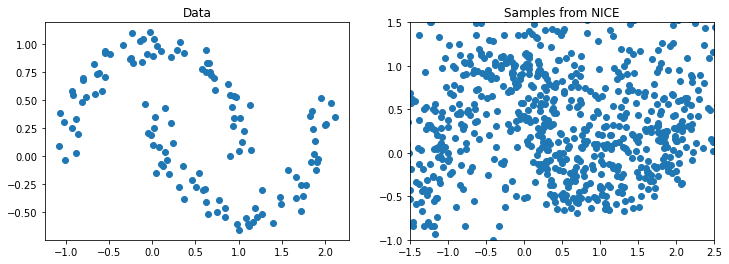

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(x[:, 0], x[:, 1])
ax[0].set_title('Data')

ax[1].scatter(samples[:, 0], samples[:, 1])
ax[1].set_title('Samples from NICE')

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

# RealNVP

Model RealNVP (Real-valued Non-Volume Preserving) jest rozszerzeniem modelu NICE, które opiera się na warstwie znanej jako Affine Coupling Layer. Analogicznie do modelu NICE, wymiary wejściowe są podzielone na dwie części:

 - Pierwsze wymiary pozostają takie same;
 - Druga część, do wymiarów, podlega transformacji afinicznej („scale-and-shift”) i zarówno parametry skali, jak i przesunięcia są funkcjami pierwszych wymiarów.

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d})})} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d})})}
\end{cases}
$$


# Ćwiczenie (5 min.)

Na podstawie powyższego kodu modelu NICE oraz biblioteki nflows zaimplementuj model RealNVP.

In [14]:
# HINT: from nflows.transforms import ...


class RealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [15]:
real_nvp = RealNVP(features=2, hidden_features=4, num_layers=2, num_blocks_per_layer=2)
real_nvp_opt = optim.Adam(real_nvp.parameters())

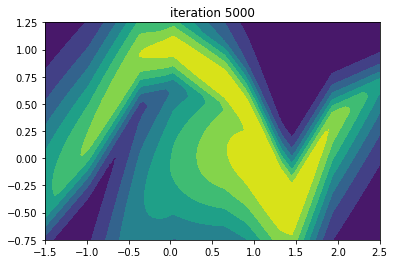

In [16]:
train(real_nvp, real_nvp_opt)

### Dalsze badanie podstawowych funkcjonalności modeli
#### Transformacje

In [17]:
prior_samples = real_nvp._distribution.sample(1000)

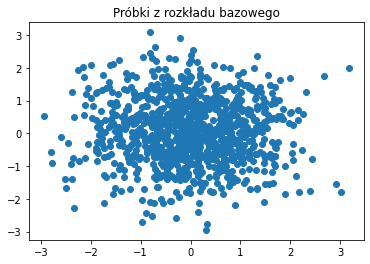

In [18]:
prior_samples_numpy = prior_samples.detach().numpy()

plt.scatter(prior_samples_numpy[:, 0], prior_samples_numpy[:, 1])
plt.title('Próbki z rozkładu bazowego')
plt.show()

In [19]:
nf_blocks = real_nvp._transform._transforms
nf_blocks

ModuleList(
  (0): AdditiveCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (final_layer): Linear(in_features=4, out_features=1, bias=True)
    )
  )
  (1): AdditiveCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): Residua

In [20]:
for transform in nf_blocks:
    print(transform)

AdditiveCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layer): Linear(in_features=4, out_features=1, bias=True)
  )
)
AdditiveCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_featur

In [21]:
consequitive_samples = [prior_samples]
current_sample = prior_samples

for transform in nf_blocks:
    current_sample, _ = transform(current_sample)
    consequitive_samples.append(current_sample)

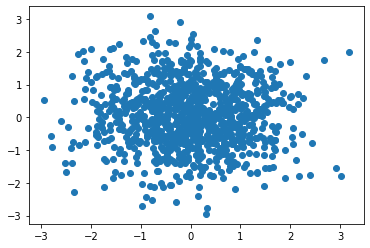

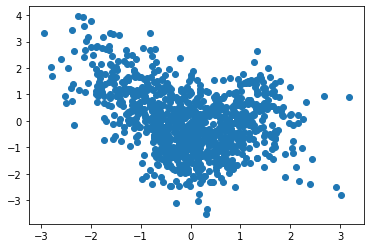

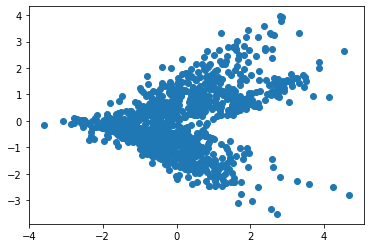

In [22]:
for s in consequitive_samples:
    s = s.detach().numpy()
    plt.scatter(s[:, 0], s[:, 1])
    plt.show()

# Masked Autoregressive Flow (MAF)

#TODO: Opis

$$p(\mathbf{x}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}})$


Przykładowo: $p(x_1, x_2) = p(x_1)p(x_2|x_1)$, gdzie $p(x_1) = \mathcal{N}(x_1|0, 4)$ i $p(x_2|x1) = \mathcal{N}(x_2|x_1^2, 1)$.

In [23]:
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


class MaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [24]:
maf = MaskedAutoregressiveFlow(features=2, hidden_features=16, num_layers=4)
maf_opt = optim.Adam(maf.parameters())

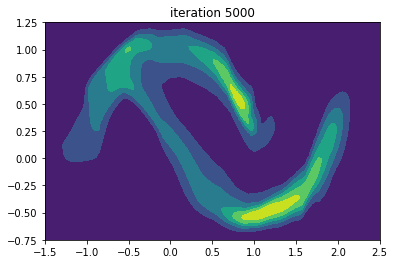

In [25]:
train(maf, maf_opt)

# Ćwiczenie (5 min.)

Zweryfikuj jak wyglądają kolejne transformacje modelu MAF analogicznie do przykładu RealNVP.

In [26]:
# TODO: Your code goes here.

# Przerwa (10 min.)

# Conditional NICE

#TODO: Opis

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})
\end{cases}
$$

In [27]:
class cNICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,  # New component
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,  # New component
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [28]:
c_nice = cNICE(features=2, hidden_features=8, num_layers=4, context_features=1)
c_nice_opt = optim.Adam(c_nice.parameters())

In [29]:
def train_conditional(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # New
        opt.zero_grad()
        loss = -model.log_prob(inputs=x, context=y).mean()  # New
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            fig, ax = plt.subplots(1, 2, figsize=(12, 8))
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid0 = model.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
                zgrid1 = model.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

            ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
            ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
            fig.suptitle('iteration {}'.format(i + 1))
            plt.show()

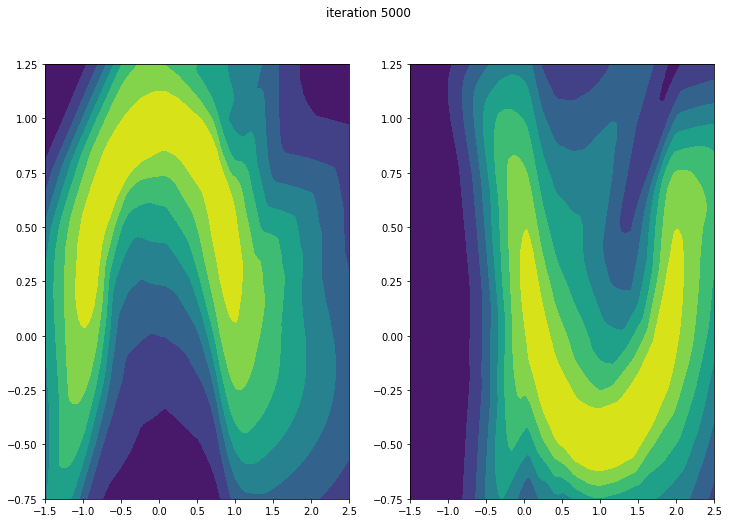

In [30]:
train_conditional(c_nice, c_nice_opt)

# Ćwiczenie (5 min.)

Wygeneruj próbki z modelu Conditional NICE dla górnego oraz dolnego półksiężyca

In [31]:
# TODO: Your code goes here.

# Ćwiczenie (10 min.)

Stwórz model Conditional RealNVP oraz model Conditional MAF analogicznie do poprzedniego przykładu. Wytrenuj przykładowe modele.

# Conditional RealNVP

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d}, \mathbf{c})})} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d}, \mathbf{c}))}}
\end{cases}
$$

In [32]:
from nflows.transforms import AffineCouplingTransform


class cRealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AffineCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [33]:
c_real_nvp = cRealNVP(features=2, hidden_features=4, context_features=1)
c_real_nvp_opt = optim.Adam(c_real_nvp.parameters())

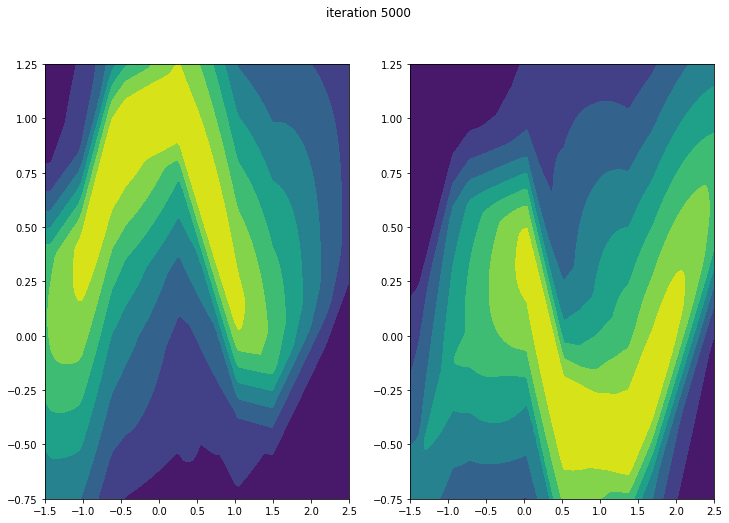

In [34]:
train_conditional(c_real_nvp, c_real_nvp_opt)

# Conditional Masked Autoregressive Flow (MAF)

$$p(\mathbf{x} | \mathbf{c}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$


In [35]:
class cMaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [36]:
c_maf = cMaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
c_maf_opt = optim.Adam(c_maf.parameters())

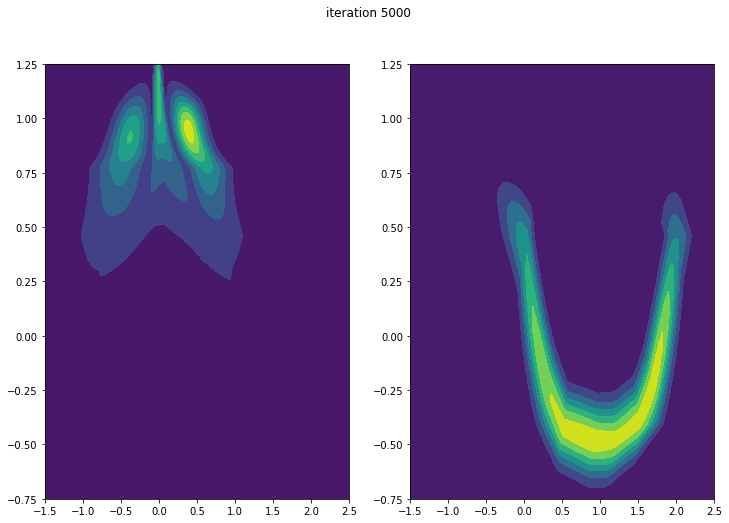

In [37]:
train_conditional(c_maf, c_maf_opt)

## Metoda Flow Plugin Network (FPN)

### Koncepcja Plugin Network

![Plugin Network](figures/plugin_koperski.png)

Pomysł:
 - Rozszerzenie istniejącej sieci neuronowej bez dodatkowego treningu, np. gdy pojawią się dane z dodatkową informację (eng. partial evidence)

Założenia koncepcji:
 - Nie przetrenowujemy oryginalnej sieci lecz jedynie trenujmy komponent plugin
 - Czas predykcji modelu jest jedynie nieznacznie większy

### Koncepcja Flow Plugin Network

 - Rozszerzenie Plugin Networku do modeli generatywnych
 - Wykorzystuje jako model bazowy - VAE
 - Wykorzystuje Conditional Normalizing Flows
 - Nie przetrenowujemy modelu bazowego


![](figures/schema-general.png)

## Trening modelu

### Kodowanie zbioru treningowego do reprezentacji ukrytej
![](figures/schema-training-encode.png)

### Trenowanie modelu Normalizing Flows
![](figures/schema-training-train.png)

## Generowanie próbek

![](figures/schema-sampling.png)

## Manipulowanie cechami obrazu

### Kodowanie obiektu
![](figures/schema-image-manipulation-encoding.png)

### Dekodowanie obiektu
![](figures/schema-image-manipulation-decode.png)

# Wykorzystanie metody FPN do warunkowego generowania obrazów

## Sample z modelu

In [38]:
model = torch.load('models/VAE.pkt')

In [39]:
model

VAE(
  (e_fc1): Linear(in_features=784, out_features=512, bias=True)
  (e_fc2): Linear(in_features=512, out_features=256, bias=True)
  (e_fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=40, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=40, bias=True)
  (d_fc1): Linear(in_features=40, out_features=128, bias=True)
  (d_fc2): Linear(in_features=128, out_features=256, bias=True)
  (d_fc3): Linear(in_features=256, out_features=512, bias=True)
  (d_fc4): Linear(in_features=512, out_features=784, bias=True)
)

In [40]:
def sample_vae(vae, z_dim, n_samples=64):
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim).to(DEVICE)
        return vae.decoder(z).to(DEVICE)

In [41]:
samples = sample_vae(model, z_dim=40, n_samples=64)

In [42]:
from torchvision.utils import save_image

save_image(samples.view(64, 1, 28, 28), f'results/samples_vae.png')

![](results/samples_vae.png)

## Kodowanie danych do latent space'u

In [43]:
import torchvision

batch_size = 500

train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [44]:
import pandas as pd

def get_latent_space(model, loader):
    zs, ys = [], []

    for x, y in loader:
        x = x.view(-1, 28*28)
        zs.append(model.sampling(*model.encoder(x)))
        ys.append(y)
    zs, ys = torch.cat(zs).detach().numpy(), torch.cat(ys).detach().numpy()

    latent_space = pd.DataFrame(zs)
    labels = pd.DataFrame({'y': ys})
    return latent_space, labels

In [45]:
train_latent_space, train_labels = get_latent_space(model, train_loader)
test_latent_space, test_labels = get_latent_space(model, test_loader)

In [46]:
train_latent_space

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.698733,-0.798542,-0.939044,0.417534,1.133281,-0.009290,1.026502,-0.817405,0.947486,-0.579681,...,-0.992131,0.403308,-0.000536,1.099308,0.662722,0.317946,-0.905271,2.654987,1.620799,-0.529896
1,0.996456,-0.390091,-2.172588,-0.949891,-1.058745,0.346047,-0.004945,-1.275585,-0.493635,0.471845,...,-0.456961,-0.834499,-0.107127,1.082984,0.752122,-1.118617,1.087954,-0.490438,1.894202,0.675633
2,1.865272,-0.510020,1.153615,-0.406908,0.869751,0.675157,0.709373,-1.162807,1.061054,1.904472,...,1.748462,0.397998,1.159022,-0.141795,-0.518797,0.541620,0.028545,0.169679,0.107454,0.701745
3,0.043390,0.134184,0.092191,-1.055219,-0.179092,-1.071774,-1.328987,0.998166,0.980153,-0.115092,...,-1.753400,-1.649004,-1.443329,0.725152,-0.986604,0.019948,-1.160237,1.040394,-0.051290,-1.096854
4,-0.419779,0.672764,0.132770,-0.683348,-0.125737,0.849942,1.997424,0.349907,1.191696,0.142574,...,1.159019,-0.096495,-0.688852,0.668220,1.560207,-0.644929,0.579570,0.406155,1.519468,-0.798672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-1.520520,0.550765,-0.202364,-1.721815,-0.207939,-0.504472,-0.347775,-1.111436,-0.261412,0.527842,...,-1.058479,0.395696,0.814007,-1.213255,-0.080945,0.355617,0.553197,0.025008,-0.268788,0.380050
59996,0.053108,-0.054149,0.248122,0.662958,-1.115371,0.497900,-0.279236,-1.132706,1.732288,0.151081,...,-1.549576,-0.161006,0.871918,-0.102509,-0.996570,0.830138,0.419013,-1.027139,-0.424015,1.367145
59997,0.035291,-1.087069,-0.930767,-1.391432,-0.459774,-0.172817,2.078584,2.214555,0.210281,0.781435,...,-0.117562,-0.770592,-0.628462,-1.106665,-0.820235,0.007334,-0.582070,0.498654,0.151287,-1.265829
59998,-2.194472,-1.149113,1.226360,-0.138477,-0.456158,-0.589933,-0.934646,0.874885,-0.077855,-0.305749,...,-0.807944,2.130304,1.193003,-1.045986,0.658637,-1.387776,0.201105,1.891880,-0.597354,1.703712


# Ćwiczenie (5 min.)

Zwizualizuj przestrzeń ukrytą z wykorzystaniem PCA, gdzie kolor będzie oznaczać klasę obiektu.

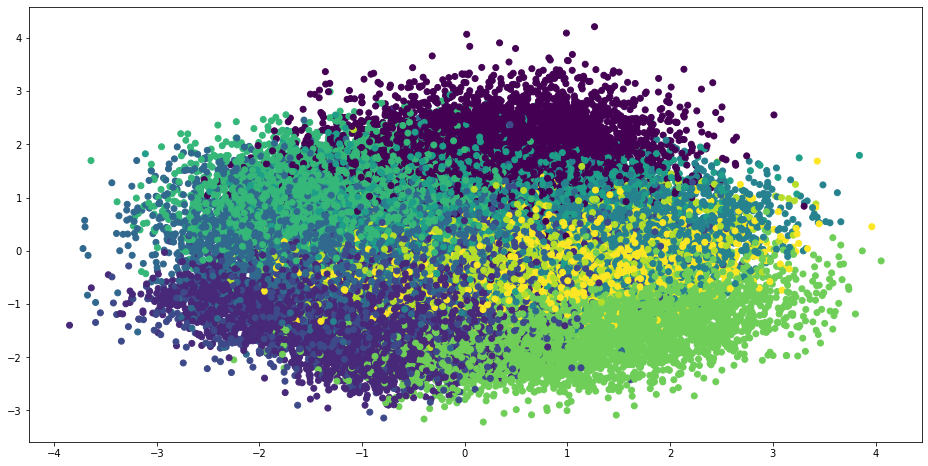

In [47]:
from sklearn.decomposition import PCA

pca = PCA()
s = pca.fit_transform(train_latent_space)

plt.figure(figsize=(16, 8))
plt.scatter(s[:, 0], s[:, 1], c=train_labels['y'])
plt.show()

## Trenowanie modelu

In [48]:
train_labels_ohe = pd.get_dummies(train_labels['y'].astype(str))

In [50]:
flow = cMaskedAutoregressiveFlow(features=40, hidden_features=40, context_features=10, num_layers=5, num_blocks_per_layer=3)
opt = optim.Adam(flow.parameters())

batch_size = 1000
num_epochs = 10

for i in range(num_epochs * (len(train_latent_space) // batch_size)):
    x = train_latent_space.sample(batch_size)
    y = train_labels_ohe.loc[x.index]

    x = torch.tensor(x.values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)

    opt.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    print(loss.item())
    loss.backward()
    opt.step()

110.82566833496094
109.77543640136719
108.71942901611328
107.65775299072266
106.56529998779297
105.49432373046875
104.40213775634766
103.31710815429688
102.1365966796875
100.93812561035156
99.76663970947266
98.45702362060547
97.07955932617188
95.66426849365234
94.1416015625
92.53328704833984
90.84542083740234
89.04068756103516
87.1062240600586
84.96083068847656
82.9372329711914
80.79652404785156
78.80470275878906
77.10812377929688
75.46417236328125
74.22952270507812
72.33462524414062
71.19253540039062
70.34519958496094
68.8420181274414
67.31161499023438
65.94725036621094
65.31424713134766
63.98358917236328
63.517459869384766
62.95186996459961
62.513099670410156
62.21487045288086
61.5121955871582
61.64735794067383
61.12739181518555
60.90482711791992
60.63711929321289
60.595211029052734
60.13908386230469
60.1711540222168
59.93805694580078
59.939517974853516
59.386070251464844
59.70158767700195
59.15143966674805
59.090694427490234
59.07872009277344
58.821815490722656
58.46183776855469
58.

# Sprawdzamy skuteczność modelu - samplowanie wybranej klasy

In [51]:
num_samples = 64

samples_latent_space_2 = flow.sample(num_samples, context=torch.Tensor([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]))
samples_latent_space_2.shape

torch.Size([1, 64, 40])

In [52]:
samples_2 = model.decoder(samples_latent_space_2.squeeze(0))

In [53]:
samples_2.shape

torch.Size([64, 784])

In [54]:
save_image(samples_2.view(num_samples, 1, 28, 28), f'results/samples_flow_2.png')

![](results/samples_flow_2.png)

# Ćwiczenie (5 min.)

Wygeneruj próbki dla innych klas.

# Inne metody

## PluGeN

### Intuicja

![](figures/PluGeN_a.png) | ![](figures/PluGeN_b.png)

### Metoda

![](figures/PluGeN_schema.png)

## StyleFlow

### Możliwości

![](figures/styleflow_teaser.png)

### Metoda

![](figures/styleflow_schema.png)

# Bibliografia / Przydatne Linki

[Normalizing Flows](https://arxiv.org/abs/1505.05770)
[Flow based deep generative models](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html#nice)
[NICE](https://arxiv.org/abs/1410.8516)
[RealNVP](https://arxiv.org/abs/1605.08803)
[MAF](https://arxiv.org/abs/1705.07057)
[Flow Plugin Network](https://arxiv.org/abs/2110.04081)
[PluGeN](https://arxiv.org/abs/2109.09011)
[StyleFlow](https://arxiv.org/abs/2008.02401)